# 🎧 User Behavior Analysis in a Music Streaming App

## Goal

The primary objective of this analysis is to explore and compare the behavior of users who **churned** (stopped using the service) versus those who **upgraded** to a paid subscription. Using a dataset of over **26 million user interaction records** from a music streaming platform (totaling 12GB), we aim to identify key differences in listening habits and mood profiles that could inform strategies for retention and conversion.

Key questions we aim to answer:
- What mood profiles dominate in upgraded vs churned users?
- Can certain mood patterns predict whether a user is likely to churn or upgrade?
- What insights can we derive to improve user engagement?

This project involves significant data processing, mood classification based on track features, and user-level aggregation and visualization.


In [5]:
import json

file_path = "data.json"
unique_pages = set()

with open(file_path, "r") as f:
    for line in f:
        try:
            data = json.loads(line)
            if "page" in data and data["page"]:  # Ensure "page" exists
                unique_pages.add(data["page"])
        except json.JSONDecodeError:
            continue  # Skip bad lines

print(sorted(unique_pages))

['About', 'Add Friend', 'Add to Playlist', 'Cancel', 'Cancellation Confirmation', 'Downgrade', 'Error', 'Help', 'Home', 'Login', 'Logout', 'NextSong', 'Register', 'Roll Advert', 'Save Settings', 'Settings', 'Submit Downgrade', 'Submit Registration', 'Submit Upgrade', 'Thumbs Down', 'Thumbs Up', 'Upgrade']


## 📦 Dataset and Preprocessing

We are working with a massive dataset (~12GB) containing over **26 million interaction records** from a music streaming platform. Each record logs a user action such as playing a track, upgrading their account, or cancelling a subscription.

Due to the size, the dataset was loaded and processed in **chunks** to avoid memory issues. Preprocessing steps included:
- Converting timestamps to datetime format for temporal analysis.
- Extracting and mapping `userId`, `level` (free/paid), and page events.
- Removing rows with missing or invalid user IDs.
- Creating a rolling view of each user’s subscription level transitions (free ➜ paid = upgrade, paid ➜ free = churn).
- Mapping song features to a **mood classification model** that categorizes tracks as `happy`, `sad`, or `neutral`.

This structured data was then used to aggregate mood profiles at the user level for both churned and upgraded groups.


In [1]:
import pandas as pd

# Adjust chunk size based on system memory (100,000 rows is safe for most)
chunk_size = 100_000
chunks = []

# Read JSON file in chunks
for chunk in pd.read_json('data.json', lines=True, chunksize=chunk_size):
    chunks.append(chunk)

# Combine all chunks into one DataFrame
df = pd.concat(chunks, ignore_index=True)
df.head()

,status,gender,length,firstName,level,lastName,registration,userId,ts,auth,page,sessionId,location,itemInSession,userAgent,song,artist,method
0,200,M,524.32934,Shlok,paid,Johnson,1.533735e+12,1749042,1538352001000,Logged In,NextSong,22683,"Dallas-Fort Worth-Arlington, TX",278,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",Ich mache einen Spiegel - Dream Part 4,Popol Vuh,PUT
1,200,F,238.39302,Vianney,paid,Miller,1.537500e+12,1563081,1538352002000,Logged In,NextSong,20836,"San Francisco-Oakland-Hayward, CA",9,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",MiÃÂ©ntele,Los Bunkers,PUT
2,200,F,140.35546,Vina,paid,Bailey,1.536415e+12,1697168,1538352002000,Logged In,NextSong,4593,"Hilo, HI",109,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.9; r...,Baby Talk,Lush,PUT
3,200,M,277.15873,Andres,paid,Foley,1.534387e+12,1222580,1538352003000,Logged In,NextSong,6370,"Watertown, SD",71,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Horn Concerto No. 4 in E flat K495: II. Romanc...,Barry Tuckwell/Academy of St Martin-in-the-Fie...,PUT
4,200,F,1121.25342,Aaliyah,paid,Ramirez,1.537381e+12,1714398,1538352003000,Logged In,NextSong,22316,"Baltimore-Columbia-Towson, MD",21,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",Close To The Edge (I. The Solid Time Of Change...,Yes,PUT


In [5]:
df["ts"] = pd.to_datetime(df["ts"], unit="ms")
df.head()

,status,gender,length,firstName,level,lastName,registration,userId,ts,auth,page,sessionId,location,itemInSession,userAgent,song,artist,method
0,200,M,524.32934,Shlok,paid,Johnson,1.533735e+12,1749042,2018-10-01 00:00:01,Logged In,NextSong,22683,"Dallas-Fort Worth-Arlington, TX",278,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",Ich mache einen Spiegel - Dream Part 4,Popol Vuh,PUT
1,200,F,238.39302,Vianney,paid,Miller,1.537500e+12,1563081,2018-10-01 00:00:02,Logged In,NextSong,20836,"San Francisco-Oakland-Hayward, CA",9,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",MiÃÂ©ntele,Los Bunkers,PUT
2,200,F,140.35546,Vina,paid,Bailey,1.536415e+12,1697168,2018-10-01 00:00:02,Logged In,NextSong,4593,"Hilo, HI",109,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.9; r...,Baby Talk,Lush,PUT
3,200,M,277.15873,Andres,paid,Foley,1.534387e+12,1222580,2018-10-01 00:00:03,Logged In,NextSong,6370,"Watertown, SD",71,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Horn Concerto No. 4 in E flat K495: II. Romanc...,Barry Tuckwell/Academy of St Martin-in-the-Fie...,PUT
4,200,F,1121.25342,Aaliyah,paid,Ramirez,1.537381e+12,1714398,2018-10-01 00:00:03,Logged In,NextSong,22316,"Baltimore-Columbia-Towson, MD",21,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",Close To The Edge (I. The Solid Time Of Change...,Yes,PUT


In [7]:
print(df.isnull().sum())  # See missing values count

df["song"].fillna("No Song Played", inplace=True)


status                 0
gender            778479
length           5408927
firstName         778479
level                  0
lastName          778479
registration      778479
userId                 0
ts                     0
auth                   0
page                   0
sessionId              0
location          778479
itemInSession          0
userAgent         778479
song             5408927
artist           5408927
method                 0
dtype: int64


C:\Users\Ibrahim Naoun\AppData\Local\Temp\ipykernel_12328\1411867047.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["song"].fillna("No Song Played", inplace=True)


In [11]:
df.columns

Index(['status', 'gender', 'length', 'firstName', 'level', 'lastName',
       'registration', 'userId', 'ts', 'auth', 'page', 'sessionId', 'location',
       'itemInSession', 'userAgent', 'song', 'artist', 'method'],
      dtype='object')

In [13]:
df.drop(columns=['firstName', 'lastName', 'status', 'itemInSession', 'method'], inplace=True)

In [39]:
df['registration'] = pd.to_datetime(df['registration'], unit='ms')
df.head()

,gender,length,level,registration,userId,ts,page,sessionId,song,artist,registration_date
0,M,524.32934,paid,2018-08-08 13:22:21,1749042,2018-10-01 00:00:01,NextSong,22683,Ich mache einen Spiegel - Dream Part 4,Popol Vuh,2018-08-08 13:22:21
1,F,238.39302,paid,2018-09-21 03:25:18,1563081,2018-10-01 00:00:02,NextSong,20836,MiÃÂ©ntele,Los Bunkers,2018-09-21 03:25:18
2,F,140.35546,paid,2018-09-08 13:48:25,1697168,2018-10-01 00:00:02,NextSong,4593,Baby Talk,Lush,2018-09-08 13:48:25
3,M,277.15873,paid,2018-08-16 02:31:00,1222580,2018-10-01 00:00:03,NextSong,6370,Horn Concerto No. 4 in E flat K495: II. Romanc...,Barry Tuckwell/Academy of St Martin-in-the-Fie...,2018-08-16 02:31:00
4,F,1121.25342,paid,2018-09-19 18:23:35,1714398,2018-10-01 00:00:03,NextSong,22316,Close To The Edge (I. The Solid Time Of Change...,Yes,2018-09-19 18:23:35


In [27]:
df.drop(columns=['status',
 'firstName',
 'lastName',
 'auth',
 'location',
 'itemInSession',
 'userAgent',
 'method'], inplace=True)
df.columns

Index(['gender', 'length', 'level', 'registration', 'userId', 'ts', 'page',
       'sessionId', 'song', 'artist', 'registration_date'],
      dtype='object')

In [31]:
df.columns

Index(['gender', 'length', 'level', 'registration', 'userId', 'ts', 'page',
       'sessionId', 'song', 'artist', 'registration_date'],
      dtype='object')

In [41]:
df.drop(columns=['registration_date'], inplace=True)

In [43]:
df.head()

,gender,length,level,registration,userId,ts,page,sessionId,song,artist
0,M,524.32934,paid,2018-08-08 13:22:21,1749042,2018-10-01 00:00:01,NextSong,22683,Ich mache einen Spiegel - Dream Part 4,Popol Vuh
1,F,238.39302,paid,2018-09-21 03:25:18,1563081,2018-10-01 00:00:02,NextSong,20836,MiÃÂ©ntele,Los Bunkers
2,F,140.35546,paid,2018-09-08 13:48:25,1697168,2018-10-01 00:00:02,NextSong,4593,Baby Talk,Lush
3,M,277.15873,paid,2018-08-16 02:31:00,1222580,2018-10-01 00:00:03,NextSong,6370,Horn Concerto No. 4 in E flat K495: II. Romanc...,Barry Tuckwell/Academy of St Martin-in-the-Fie...
4,F,1121.25342,paid,2018-09-19 18:23:35,1714398,2018-10-01 00:00:03,NextSong,22316,Close To The Edge (I. The Solid Time Of Change...,Yes


## 💾 Data Cleaning & Saving

After cleaning and filtering out incomplete or irrelevant records, the dataset was significantly reduced in size while retaining all meaningful user interactions. To ensure faster loading and efficient access in subsequent steps, the cleaned DataFrame was saved in **Parquet format**.

Parquet offers:
- Columnar storage for faster queries.
- Efficient compression.
- Compatibility with large-scale analytics.

This prepared dataset becomes the foundation for further analysis such as identifying subscription transitions and mood-based behavior segmentation.


In [45]:
df.to_parquet("data.parquet", index=False)

In [2]:
import pandas as pd
df = pd.read_parquet('data.parquet') 


df.head()

,gender,length,level,registration,userId,ts,page,sessionId,song,artist
0,M,524.32934,paid,2018-08-08 13:22:21,1749042,2018-10-01 00:00:01,NextSong,22683,Ich mache einen Spiegel - Dream Part 4,Popol Vuh
1,F,238.39302,paid,2018-09-21 03:25:18,1563081,2018-10-01 00:00:02,NextSong,20836,MiÃÂ©ntele,Los Bunkers
2,F,140.35546,paid,2018-09-08 13:48:25,1697168,2018-10-01 00:00:02,NextSong,4593,Baby Talk,Lush
3,M,277.15873,paid,2018-08-16 02:31:00,1222580,2018-10-01 00:00:03,NextSong,6370,Horn Concerto No. 4 in E flat K495: II. Romanc...,Barry Tuckwell/Academy of St Martin-in-the-Fie...
4,F,1121.25342,paid,2018-09-19 18:23:35,1714398,2018-10-01 00:00:03,NextSong,22316,Close To The Edge (I. The Solid Time Of Change...,Yes


In [10]:
print(df['ts'].max())
df['ts'].min()

2018-12-01 00:00:02


Timestamp('2018-10-01 00:00:01')

In [12]:
df.isnull().sum()

gender           778479
length          5408927
level                 0
registration     778479
userId                0
ts                    0
page                  0
sessionId             0
song                  0
artist          5408927
dtype: int64

## 🔍 Missing Data Investigation

A quick inspection of null values revealed a few columns with significant missing data:

- `length`: ~5.4 million nulls  
- `artist`: ~5.4 million nulls  
- `gender` and `registration`: ~778,479 nulls each  

Notably, the null counts for `gender` and `registration` matched exactly, suggesting they likely originate from the same incomplete user records. This observation triggered a deeper investigation into users lacking demographic and registration data, to determine whether these entries are system-related, anonymous sessions, or represent incomplete logs.

This step was essential before deciding on data cleaning rules, to avoid accidentally dropping valuable user behavior.


In [47]:
null_reg_rows = df[df['registration'].isnull()]
null_reg_rows.head(20)


,gender,length,level,registration,userId,ts,page,sessionId,song,artist
17,None,NaN,paid,NaT,1261737,2018-10-01 00:00:08,Home,8615,No Song Played,None
71,None,NaN,free,NaT,1261737,2018-10-01 00:00:41,Login,7433,No Song Played,None
354,None,NaN,free,NaT,1261737,2018-10-01 00:03:02,Home,25003,No Song Played,None
472,None,NaN,free,NaT,1261737,2018-10-01 00:04:14,Home,9930,No Song Played,None
476,None,NaN,free,NaT,1261737,2018-10-01 00:04:15,Login,9930,No Song Played,None
481,None,NaN,free,NaT,1261737,2018-10-01 00:04:19,Login,23471,No Song Played,None
514,None,NaN,free,NaT,1261737,2018-10-01 00:04:38,Home,6317,No Song Played,None
676,None,NaN,free,NaT,1261737,2018-10-01 00:06:01,Home,22951,No Song Played,None
688,None,NaN,free,NaT,1261737,2018-10-01 00:06:05,Home,22951,No Song Played,None
763,None,NaN,paid,NaT,1261737,2018-10-01 00:06:44,Home,6071,No Song Played,None


In [49]:
null_reg_rows['page'].unique()

array(['Home', 'Login', 'Help', 'About', 'Error', 'Register',
       'Submit Registration'], dtype=object)

In [53]:
null_reg_rows.isnull().sum()

gender          778479
length          778479
level                0
registration    778479
userId               0
ts                   0
page                 0
sessionId            0
song                 0
artist          778479
dtype: int64

In [55]:
null_reg_rows['song'].value_counts()['No Song Played']

778479

In [57]:
df['userId'].nunique()

22278

In [61]:
null_reg_rows['userId'].nunique()

1

### 🧹 Null User Identification

Further inspection of rows with missing `gender` and `registration` revealed that they all belonged to a single user.


In [63]:
null_reg_rows.describe()

,length,registration,userId,ts,sessionId
count,0.0,0,778479.0,778479,778479.000000
mean,NaN,NaT,1261737.0,2018-10-29 21:29:14.469032448,97802.090322
min,NaN,NaT,1261737.0,2018-10-01 00:00:08,1.000000
25%,NaN,NaT,1261737.0,2018-10-14 17:04:06.500000,27877.000000
50%,NaN,NaT,1261737.0,2018-10-29 08:28:06,89864.000000
75%,NaN,NaT,1261737.0,2018-11-13 21:30:12,160908.000000
max,NaN,NaT,1261737.0,2018-11-30 23:59:49,240381.000000
std,NaN,NaN,0.0,NaN,72052.920354


In [3]:
df.isnull().sum()

gender           778479
length          5408927
level                 0
registration     778479
userId                0
ts                    0
page                  0
sessionId             0
song                  0
artist          5408927
dtype: int64

In [7]:
df['userId'].value_counts()[1261737]

778479

In [9]:
df1 = df[df['userId'] == 1261737]
df1.head()

,gender,length,level,registration,userId,ts,page,sessionId,song,artist
17,None,NaN,paid,NaT,1261737,2018-10-01 00:00:08,Home,8615,No Song Played,None
71,None,NaN,free,NaT,1261737,2018-10-01 00:00:41,Login,7433,No Song Played,None
354,None,NaN,free,NaT,1261737,2018-10-01 00:03:02,Home,25003,No Song Played,None
472,None,NaN,free,NaT,1261737,2018-10-01 00:04:14,Home,9930,No Song Played,None
476,None,NaN,free,NaT,1261737,2018-10-01 00:04:15,Login,9930,No Song Played,None


In [17]:
df1.isnull().sum()

gender          778479
length          778479
level                0
registration    778479
userId               0
ts                   0
page                 0
sessionId            0
song                 0
artist          778479
dtype: int64

In [19]:
df1['level'].value_counts()['paid']

523348

In [21]:
df1['page'].unique()

array(['Home', 'Login', 'Help', 'About', 'Error', 'Register',
       'Submit Registration'], dtype=object)

In [27]:
df1[df1['page'] == 'Submit Registration']

,gender,length,level,registration,userId,ts,page,sessionId,song,artist
212861,None,NaN,free,NaT,1261737,2018-10-01 18:26:07,Submit Registration,15002,No Song Played,None
217624,None,NaN,free,NaT,1261737,2018-10-01 18:43:59,Submit Registration,15002,No Song Played,None
505777,None,NaN,free,NaT,1261737,2018-10-02 16:05:20,Submit Registration,15065,No Song Played,None
645953,None,NaN,free,NaT,1261737,2018-10-03 01:14:42,Submit Registration,20297,No Song Played,None
654144,None,NaN,free,NaT,1261737,2018-10-03 01:51:55,Submit Registration,15004,No Song Played,None
...,...,...,...,...,...,...,...,...,...,...
25705591,None,NaN,free,NaT,1261737,2018-11-20 17:55:35,Submit Registration,36086,No Song Played,None
25745445,None,NaN,free,NaT,1261737,2018-11-21 10:22:54,Submit Registration,38674,No Song Played,None
25796727,None,NaN,free,NaT,1261737,2018-11-22 07:07:35,Submit Registration,38507,No Song Played,None
25986229,None,NaN,free,NaT,1261737,2018-11-26 17:42:13,Submit Registration,2527,No Song Played,None


In [33]:
df['page'].value_counts()['Submit Registration']

401

### 🧹 Null Data Investigation & Cleanup

A detailed inspection of the `registration` and `gender` columns showed 778,479 missing values, all tied to a single user. Additionally, this user was the only one triggering the `'Submit Registration'` page. This strongly suggests that the registration-related data corresponds to either test data or an incomplete registration loop.

Since this user contributes a disproportionate number of nulls and does not represent meaningful behavioral patterns, we decided to remove all rows related to this user and discard any analysis or assumptions based on `'Submit Registration'`.


In [ ]:
# Remove user with userId 1261737
df = df[df['userId'] != 1261737]

## Identifying User Transitions: Churned vs Upgraded

With the dataset cleaned and irrelevant entries removed, the next step is to identify user behavior transitions — specifically:

- **Churned Users**: Users who downgraded from paid to free.
- **Upgraded Users**: Users who upgraded from free to paid.

We track these transitions by analyzing each user's sequence of events and monitoring changes in their subscription `level` over time. This step is crucial for understanding how user engagement relates to upgrade and


In [35]:
df['level'].value_counts()['paid']

20595828

In [37]:
df['page'].unique()

array(['NextSong', 'Home', 'Thumbs Up', 'Error', 'Help',
       'Add to Playlist', 'Roll Advert', 'Login', 'Thumbs Down',
       'Settings', 'About', 'Add Friend', 'Upgrade', 'Submit Upgrade',
       'Logout', 'Downgrade', 'Save Settings', 'Submit Downgrade',
       'Cancel', 'Cancellation Confirmation', 'Register',
       'Submit Registration'], dtype=object)

In [39]:
df['page'].value_counts()['Submit Upgrade']

15135

In [41]:
df['page'].value_counts()['Upgrade']

50507

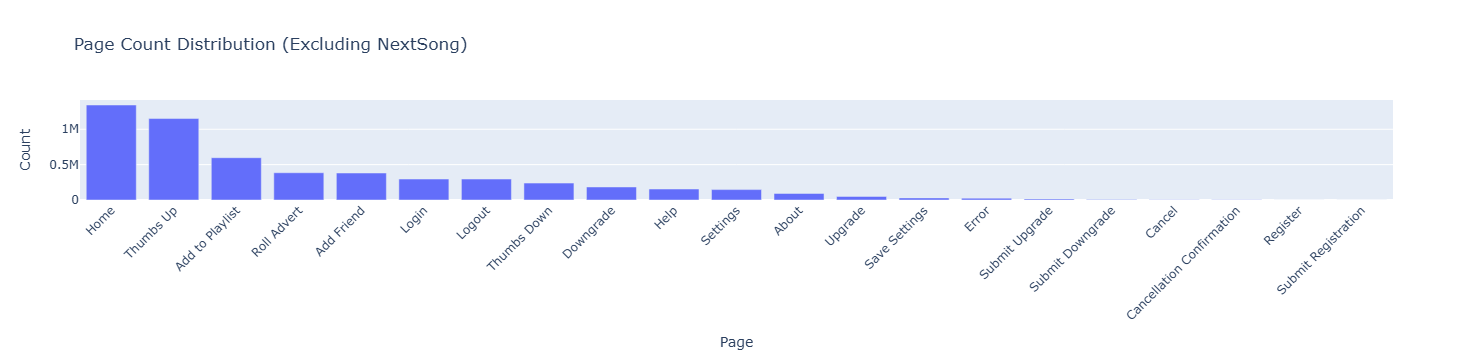

In [55]:
import plotly.express as px

# Drop 'NextSong' from the counts
page_counts = df['page'].value_counts().drop('NextSong').reset_index()
page_counts.columns = ['Page', 'Count']

# Create the interactive plot
fig = px.bar(page_counts, x='Page', y='Count', title='Page Count Distribution (Excluding NextSong)',
             labels={'Count': 'Count', 'Page': 'Page'},
             hover_data={'Count': True})

fig.update_layout(xaxis_tickangle=-45)
fig.show()


In [57]:
df[df['page'] == 'Cancellation Confirmation']['userId'].nunique()

5003

## Attempting Mood Classification via Spotify API

To better understand user behavior on the music platform, we aimed to classify the emotional mood of songs users listened to. The initial idea was to use the **Spotify Web API** to enrich our dataset by assigning moods (`happy`, `sad`, `neutral`) to each song.

We filtered the 12GB dataset to include only entries where the `song` field was not null, and then attempted to send those unique song titles to Spotify’s API in batches.

The goal was to retrieve audio features such as `valence`, `energy`, and `danceability`, which could then be used to infer the mood of each track. These song-level moods would later be aggregated to build user mood profiles.

However, this process encountered several limitations — including low match rates due to inconsistent naming and API rate limits — which are discussed in the following section.


In [103]:
pip install spotipy


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [105]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

# Replace with credentials
CLIENT_ID = ''
CLIENT_SECRET = ''

# Authentication
client_credentials_manager = SpotifyClientCredentials(client_id=CLIENT_ID, client_secret=CLIENT_SECRET)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)


In [ ]:
import spotipy
import pandas as pd
import time

# Function to get the valence (mood) of a song
def get_song_mood(song_name, artist_name):
    # Skip if song or artist is 'No Song Played' or 'None'
    if song_name == "No Song Played" or artist_name == "None":
        return None
    
    query = f"{song_name} {artist_name}"
    result = sp.search(q=query, type='track', limit=1)
    
    if result['tracks']['items']:
        track = result['tracks']['items'][0]
        track_id = track['id']
        try:
            features = sp.audio_features(track_id)[0]
            return features['valence']  # Return the valence as the mood (higher = positive, lower = negative)
        except Exception as e:
            print(f"Error fetching features for {song_name}: {e}")
            return None
    return None  # Return None if no result found

# Apply this function to your DataFrame to get the mood for each song
def add_song_mood(df):
    moods = []
    for idx, row in df.iterrows():
        song_name = row['song']
        artist_name = row['artist']
        mood = get_song_mood(song_name, artist_name)
        moods.append(mood)
        
        # Add a small delay between requests to avoid rate limiting
        time.sleep(0.2)  # Adjust the delay as needed (0.2 seconds is a safe choice)
    
    df['mood'] = moods  # Add the mood column to the DataFrame
    return df

# Assuming your DataFrame is called df
df_with_mood = add_song_mood(df)

# Show the updated DataFrame
df_with_mood.head()


### Limitations of the Spotify API Approach

Despite our initial effort, the Spotify API method failed to deliver usable results. The main issues were:

- **Low match rate** due to inconsistent or incomplete song metadata.
- **Rate limits** imposed by the API, making large-scale retrieval impractical.

As a result, we decided to drop this approach and moved toward using some music datasets.


In [6]:
import pandas as pd


df = pd.read_parquet("data.parquet")

# Quick check
df.head()


,gender,length,level,registration,userId,ts,page,sessionId,song,artist
0,M,524.32934,paid,2018-08-08 13:22:21,1749042,2018-10-01 00:00:01,NextSong,22683,Ich mache einen Spiegel - Dream Part 4,Popol Vuh
1,F,238.39302,paid,2018-09-21 03:25:18,1563081,2018-10-01 00:00:02,NextSong,20836,MiÃÂ©ntele,Los Bunkers
2,F,140.35546,paid,2018-09-08 13:48:25,1697168,2018-10-01 00:00:02,NextSong,4593,Baby Talk,Lush
3,M,277.15873,paid,2018-08-16 02:31:00,1222580,2018-10-01 00:00:03,NextSong,6370,Horn Concerto No. 4 in E flat K495: II. Romanc...,Barry Tuckwell/Academy of St Martin-in-the-Fie...
4,F,1121.25342,paid,2018-09-19 18:23:35,1714398,2018-10-01 00:00:03,NextSong,22316,Close To The Edge (I. The Solid Time Of Change...,Yes


### Optimization: Extracting Unique Songs

To optimize our processing , we extracted unique song entries from the dataset. This reduced the size significantly and allowed us to focus only on distinct songs when applying classification logic.


In [8]:
# Filter valid entries
valid_songs = df[(df['song'] != 'No Song Played') & (df['artist'] != 'None')]

# Drop duplicates
unique_songs = valid_songs[['song', 'artist']].drop_duplicates()

# Print count
print("Number of unique songs:", len(unique_songs))

# Save to CSV
unique_songs.to_csv("unique_songs.csv", index=False)


Number of unique songs: 311148


In [11]:
df_sample=df[df['song'] != 'No Song Played'].sample(n=1000, random_state=42)

In [13]:
df_sample.head()

,gender,length,level,registration,userId,ts,page,sessionId,song,artist
13421564,F,220.70812,paid,2018-08-20 00:35:33,1920200,2018-11-09 23:33:34,NextSong,174910,For Emma,Bon Iver
6628823,M,243.22567,paid,2018-08-28 06:27:42,1101574,2018-10-20 21:33:14,NextSong,90147,Git Up,D-12
17259808,F,186.48771,paid,2018-08-29 12:38:16,1593594,2018-11-22 04:40:31,NextSong,173127,Breed,Nirvana
2911676,M,236.82567,paid,2018-09-01 05:37:13,1651754,2018-10-10 02:47:37,NextSong,62681,I Go Ka,Ali Farka TourÃÂ©
17357126,M,612.70159,paid,2018-09-30 20:46:39,1310926,2018-11-22 15:13:48,NextSong,209496,A Farewell To Arms (Explicit Album Version),Machine Head


### Matching with External Dataset: Spotify MillSongData

We used the `spotify_millsongdata` dataset as a reference to identify mood-related metadata for our songs.


In [ ]:
import pandas as pd

# Load the CSV files
file1 = pd.read_csv('unique_songs.csv')
file2 = pd.read_csv('spotify_millsongdata.csv')

song_names_file1 = file1['song']
song_names_file2 = file2['song']

# Check if each song in file1 exists in file2
exists_in_file2 = song_names_file1.isin(song_names_file2)

# Add a new column to indicate if the song exists in the second file
file1['exists_in_file2'] = exists_in_file2

# Display the result
print(file1[['song', 'exists_in_file2']])

In [6]:
print(file1[['song', 'exists_in_file2']])

                                                     song  exists_in_file2
0                  Ich mache einen Spiegel - Dream Part 4            False
1                                             MiÃÂ©ntele            False
2                                               Baby Talk             True
3       Horn Concerto No. 4 in E flat K495: II. Romanc...            False
4       Close To The Edge (I. The Solid Time Of Change...            False
...                                                   ...              ...
311143                                      Well Fed Fuck            False
311144                             Get Ready (LP Version)            False
311145                       Body Destroyed_ Brain Intact            False
311146                                  Back In The Alley            False
311147                                        Provocative            False

[311148 rows x 2 columns]


In [8]:
# Count the number of True values in the 'exists_in_file2' column
true_count = file1['exists_in_file2'].sum()

# Print the result
print(f"Number of songs in file1 that exist in file2: {true_count}")


Number of songs in file1 that exist in file2: 52447


### Extracting Mood from Lyrics Using VADER

Since the matching with `spotify_millsongdata` was limited `52k out of 301k`, we leveraged the available lyrics to infer song moods. We used the VADER (Valence Aware Dictionary and sEntiment Reasoner) sentiment analysis tool to compute sentiment scores for each song's lyrics. These scores were then used to classify each song into one of three mood categories: **happy**, **sad**, or **neutral**.


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()
# Assuming the column containing song lyrics is called 'lyrics'
lyrics = file2['text']

# Function to get sentiment from lyrics
def get_sentiment(lyrics):
    sentiment_score = analyzer.polarity_scores(lyrics)
    return sentiment_score['compound']  # Compound score represents overall sentiment

# Apply sentiment analysis on each song's lyrics
file2['sentiment_score'] = lyrics.apply(get_sentiment)

# Define mood based on sentiment score
def get_mood(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Apply mood classification
file2['mood'] = file2['sentiment_score'].apply(get_mood)

# Display the result
print(file2[['song_name', 'mood']])


In [22]:
print(file2[['song', 'mood']])

                        song      mood
0      Ahe's My Kind Of Girl  Positive
1           Andante, Andante  Positive
2             As Good As New  Positive
3                       Bang  Positive
4           Bang-A-Boomerang  Positive
...                      ...       ...
57645          Good Old Days  Positive
57646          Hand To Mouth  Negative
57647           Come With Me  Positive
57648                 Desire  Negative
57649              Heartsong  Positive

[57650 rows x 2 columns]


In [32]:
common_songs = file1[file1['song'].isin(file2['song'])]

# Merge the moods from file2 into the common songs from file1
common_songs_with_mood = common_songs.merge(file2[['song', 'mood']], on='song', how='left')

In [34]:
common_songs_with_mood

,song,artist,exists_in_file2,mood
0,Baby Talk,Lush,True,Positive
1,Electric Feel,MGMT,True,Positive
2,Mockingbird,Eminem,True,Positive
3,Mockingbird,Eminem,True,Positive
4,Forgive Me,Leona Lewis,True,Negative
...,...,...,...,...
180205,Ruins,Rise & Fall,True,Positive
180206,Stranger,Black N Blue,True,Positive
180207,Stranger,Black N Blue,True,Negative
180208,Stranger,Black N Blue,True,Positive


In [51]:
unique_song_count = file1['song'].unique()
unique_song_count

array(['Ich mache einen Spiegel - Dream Part 4', 'MiÃ\x83Â©ntele',
       'Baby Talk', ..., 'Well Fed Fuck', 'Body Destroyed_ Brain Intact',
       'Provocative'], dtype=object)

In [38]:
# Remove duplicates based on the 'song' column
common_songs_with_mood_no_duplicates = common_songs_with_mood.drop_duplicates(subset='song')

# Display the result without duplicates
common_songs_with_mood_no_duplicates[['song', 'mood']]

,song,mood
0,Baby Talk,Positive
1,Electric Feel,Positive
2,Mockingbird,Positive
4,Forgive Me,Negative
6,Anytime You Need A Friend,Positive
...,...,...
180112,It's A Sin,Negative
180142,The Spy,Positive
180157,Can't Sleep,Positive
180170,Simmer Down,Negative


In [40]:
common_songs_with_mood_no_duplicates.to_csv('common_songs_with_moods_no_duplicates.csv', index=False)

### Integrating Mood Data into Main Dataset

After obtaining mood classifications from VADER, we merged this mood information back into our main dataset. Songs that were matched and had corresponding mood labels were updated accordingly. For songs that didn't have any match or lyrics available, their mood was marked as `None` to maintain consistency and enable filtering in later analysis.


In [43]:


# Load the large dataset (26 million records)
data = pd.read_parquet('data.parquet')

# Load the common songs with moods (unique songs from file2)
common_songs_with_mood = pd.read_csv('common_songs_with_moods_no_duplicates.csv')

# Create a mapping of 'song' -> 'mood' from common_songs_with_mood
song_to_mood = dict(zip(common_songs_with_mood['song'], common_songs_with_mood['mood']))

# Function to assign mood based on the song
def assign_mood(song):
    return song_to_mood.get(song, None)  # If the song is not found, return None (null)

# Apply the function to the 'song' column to create the 'mood' column
data['mood'] = data['song'].apply(assign_mood)
data.head()

,gender,length,level,registration,userId,ts,page,sessionId,song,artist,mood
0,M,524.32934,paid,2018-08-08 13:22:21,1749042,2018-10-01 00:00:01,NextSong,22683,Ich mache einen Spiegel - Dream Part 4,Popol Vuh,None
1,F,238.39302,paid,2018-09-21 03:25:18,1563081,2018-10-01 00:00:02,NextSong,20836,MiÃÂ©ntele,Los Bunkers,None
2,F,140.35546,paid,2018-09-08 13:48:25,1697168,2018-10-01 00:00:02,NextSong,4593,Baby Talk,Lush,Positive
3,M,277.15873,paid,2018-08-16 02:31:00,1222580,2018-10-01 00:00:03,NextSong,6370,Horn Concerto No. 4 in E flat K495: II. Romanc...,Barry Tuckwell/Academy of St Martin-in-the-Fie...,None
4,F,1121.25342,paid,2018-09-19 18:23:35,1714398,2018-10-01 00:00:03,NextSong,22316,Close To The Edge (I. The Solid Time Of Change...,Yes,None


In [45]:
data.isnull().sum()

gender            778479
length           5408927
level                  0
registration      778479
userId                 0
ts                     0
page                   0
sessionId              0
song                   0
artist           5408927
mood            20609383
dtype: int64

In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26259199 entries, 0 to 26259198
Data columns (total 11 columns):
 #   Column        Dtype         
---  ------        -----         
 0   gender        object        
 1   length        float64       
 2   level         object        
 3   registration  datetime64[ns]
 4   userId        int64         
 5   ts            datetime64[ns]
 6   page          object        
 7   sessionId     int64         
 8   song          object        
 9   artist        object        
 10  mood          object        
dtypes: datetime64[ns](2), float64(1), int64(2), object(6)
memory usage: 2.2+ GB


In [49]:
data.to_parquet('updated_data.parquet', index=False)

In [61]:
file2 = pd.read_csv('unique_songs.csv')
file2_no_duplicates = file2.drop_duplicates(subset='song')


In [63]:
file2_no_duplicates

,song,artist
0,Ich mache einen Spiegel - Dream Part 4,Popol Vuh
1,MiÃÂ©ntele,Los Bunkers
2,Baby Talk,Lush
3,Horn Concerto No. 4 in E flat K495: II. Romanc...,Barry Tuckwell/Academy of St Martin-in-the-Fie...
4,Close To The Edge (I. The Solid Time Of Change...,Yes
...,...,...
311140,Que va a ser,Fran Perea
311142,Case # obscene,DISMEMBER
311143,Well Fed Fuck,Born Against
311145,Body Destroyed_ Brain Intact,Dysrhythmia


In [65]:
file2_no_duplicates.to_csv('unique.csv', index=False)

### Expanding Mood Coverage with Additional Datasets

To improve our song mood coverage, we incorporated two additional datasets: one from Spotify and another from the Wasabi project. These datasets provided mood-related features for a large portion of our songs.

This step wasn't without challenges. The **Wasabi dataset**, for instance, is around **4.4GB**, and handling it efficiently proved difficult due to memory constraints. While the code for parsing it wasn't preserved, it involved several trials with chunked reading and optimization to extract the needed fields.


In [29]:
import pandas as pd

# Load unique songs
unique = pd.read_csv('unique.csv', usecols=['song'])
unique_set = set(unique['song'].str.lower().dropna().unique())

# Load Wasabi song titles
wasabi = pd.read_csv('wasabi_songs.csv', sep='\t', usecols=['title'])
wasabi_set = set(wasabi['title'].str.lower().dropna().unique())

# Load Spotify datasets
spotify1 = pd.read_csv('spotify_data.csv', usecols=['track_name'])
spotify2 = pd.read_csv('spotify_millsongdata.csv', usecols=['song'])

spotify1_set = set(spotify1['track_name'].str.lower().dropna().unique())
spotify2_set = set(spotify2['song'].str.lower().dropna().unique())

# Combine all source sets
all_sources = wasabi_set | spotify1_set | spotify2_set

# Find intersection with unique.csv
covered_songs = unique_set & all_sources

# Result
print(f"✅ {len(covered_songs)} / {len(unique_set)} unique songs are covered across Wasabi + both Spotify files.")
print(f"📉 {len(unique_set) - len(covered_songs)} songs are still uncovered.")


✅ 142342 / 250372 unique songs are covered across Wasabi + both Spotify files.
📉 108030 songs are still uncovered.


In [31]:
wasabi_covered = unique_set & wasabi_set
spotify1_covered = unique_set & spotify1_set
spotify2_covered = unique_set & spotify2_set

print(f"🎵 Wasabi matched: {len(wasabi_covered)}")
print(f"🎧 Spotify1 matched: {len(spotify1_covered)}")
print(f"🎶 Spotify2 matched: {len(spotify2_covered)}")


🎵 Wasabi matched: 131313
🎧 Spotify1 matched: 79556
🎶 Spotify2 matched: 17843


In [33]:
import pandas as pd

# Load unique song list
unique_df = pd.read_csv('unique.csv', usecols=['song'])
unique_df['song_lower'] = unique_df['song'].str.lower()

# Convert the full covered song set to lowercase for matching
covered_set = set(song.lower() for song in covered_songs)

# Split the DataFrame
covered_df = unique_df[unique_df['song_lower'].isin(covered_set)].drop(columns=['song_lower'])
uncovered_df = unique_df[~unique_df['song_lower'].isin(covered_set)].drop(columns=['song_lower'])

# Save to new files
covered_df.to_csv('unique_covered.csv', index=False)
uncovered_df.to_csv('unique_uncovered.csv', index=False)

print("✅ Done! Saved:")
print(f"🟢 {len(covered_df)} songs → 'unique_covered.csv'")
print(f"🔴 {len(uncovered_df)} songs → 'unique_uncovered.csv'")


✅ Done! Saved:
🟢 145388 songs → 'unique_covered.csv'
🔴 108176 songs → 'unique_uncovered.csv'


✅ **142,342 / 250,372** unique songs were successfully matched using these additional sources.  
📉 **108,030** songs remained unmatched after this step.

Breakdown of matched songs:
- 🎵 **Wasabi dataset**: 131,313 songs matched  
- 🎧 **Spotify Dataset 1**: 79,556 songs matched  
- 🎶 **Spotify Dataset 2**: 17,843 songs matched  

This significantly expanded our mood labeling capacity and helped enhance the reliability of mood-based user behavior analysis.

### Investigating Unmatched Songs

After matching 142,342 songs using multiple datasets, we were left with **108,030 unmatched songs** — nearly 43% of the total unique songs. Understanding the nature of these unmatched entries was crucial to ensure they wouldn’t introduce bias or blind spots in our mood-based user profiling.

We began by analyzing these songs to determine patterns in missing data, inconsistencies in naming formats, or other characteristics that may have hindered their mapping. Our goal was to either clean and recover more matches or clearly define this unmatched group for exclusion or alternative processing.


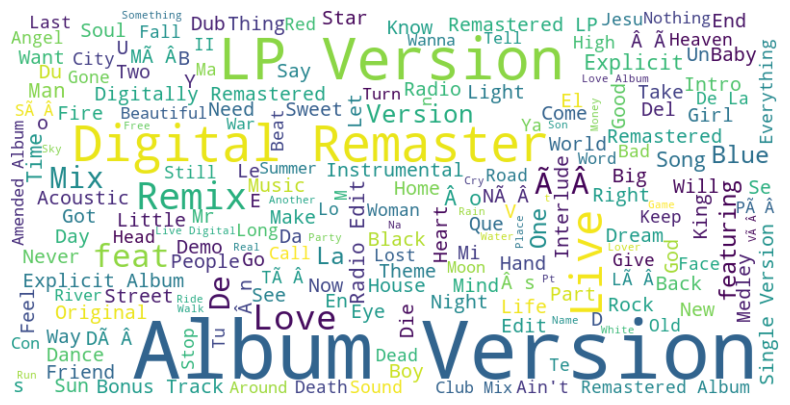

In [41]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


uncovered_df = pd.read_csv('unique_uncovered.csv')

# Join all song titles into a single text
text = ' '.join(uncovered_df['song'].dropna())

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Don't show axes
plt.show()


In [45]:

# Load the uncovered songs
uncovered_df = pd.read_csv("unique_uncovered.csv")

# Common noisy keywords
keywords = ['album version', 'remaster', 'lp version', 'feat', 'featuring', 'remix', 
            'live', 'explicit', 'edit', 'bonus track', 'instrumental', 'demo', 
            'radio edit', 'version', 'mix', 'single version']

# Ensure 'song' column exists and lowercase it safely
uncovered_df['song_lower'] = uncovered_df['song'].astype(str).str.lower()

# Check for presence of any keywords
uncovered_df['has_keyword'] = uncovered_df['song_lower'].apply(
    lambda title: any(keyword in title for keyword in keywords)
)

# Count how many have keywords
num_with_keywords = uncovered_df['has_keyword'].sum()
total_uncovered = len(uncovered_df)

print(f"🎯 {num_with_keywords} / {total_uncovered} songs ({num_with_keywords/total_uncovered:.2%}) contain common keyword patterns.")

🎯 42145 / 108176 songs (38.96%) contain common keyword patterns.


### Investigating Unmatched Songs (Continued)

Upon inspecting the unmatched 108,030 songs, we discovered that **approximately 38%** of them contained modifiers and metadata in their titles such as: `album version`,`Remix`..etc

These additions often obstructed direct string matching. To address this, we implemented preprocessing techniques including:

- **Lowercasing** all titles for consistency
- **Regex filtering** to remove common descriptors
- Trimming extra whitespace and symbols

This step helped us clean the data for better fuzzy or partial matching in subsequent steps.



In [1]:
import pandas as pd
import re
import unicodedata


df = pd.read_csv("unique_uncovered.csv")

# Define keywords (as regex pattern parts)
keywords = [
    'album version', 'lp version', 'remaster(ed)?', 'feat(\.|uring)?', 'live', 
    'explicit', 'radio edit', 'version', 'remix', 'demo', 'bonus track',
    'instrumental', 'single version', 'edit', 'mix', 'interlude'
]

# Regex pattern for keywords and special characters
keyword_pattern = re.compile(r'\b(' + '|'.join(keywords) + r')\b', flags=re.IGNORECASE)
special_chars_pattern = re.compile(r"[&é\"=)\(àç_è\-]")

# Function to normalize accents
def normalize_accents(text):
    return unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore').decode('utf-8')

# Full cleaning function
def clean_title(title):
    if pd.isna(title): return ''
    title = str(title).lower()
    title = normalize_accents(title)
    title = keyword_pattern.sub('', title)
    title = special_chars_pattern.sub('', title)
    title = re.sub(r'\s+', ' ', title)
    return title.strip()

# Apply cleaning
df['song_cleaned'] = df['song'].apply(clean_title)

# Save to CSV
df.to_csv("unique_uncovered_cleaned.csv", index=False)

print("✅ Cleaned, accent-normalized song names saved to 'unique_uncovered_cleaned.csv'")


<>:10: SyntaxWarning: invalid escape sequence '\.'
<>:10: SyntaxWarning: invalid escape sequence '\.'
C:\Users\Ibrahim Naoun\AppData\Local\Temp\ipykernel_1940\739060992.py:10: SyntaxWarning: invalid escape sequence '\.'
  'album version', 'lp version', 'remaster(ed)?', 'feat(\.|uring)?', 'live',


✅ Cleaned, accent-normalized song names saved to 'unique_uncovered_cleaned.csv'


In [3]:
df.head(15)

,song,song_cleaned
0,Ich mache einen Spiegel - Dream Part 4,ich mache einen spiegel dream part 4
1,MiÃÂ©ntele,miaantele
2,Horn Concerto No. 4 in E flat K495: II. Romanc...,horn concerto no. 4 in e flat k495: ii. romanc...
3,Close To The Edge (I. The Solid Time Of Change...,close to the edge i. the solid time of change ...
4,Ah Que La Vie Est Belle,ah que la vie est belle
5,Los Angeles_ I'm Yours,los angeles i'm yours
6,Carousel (Album),carousel album
7,Barfight Revolution_ Power Violence,barfight revolution power violence
8,Ignorance (Album Version),ignorance
9,What Is Light? Where Is Laughter? (Album Version),what is light? where is laughter?


In [9]:
import pandas as pd
import unicodedata
import re

# Load cleaned unique uncovered songs
unique_cleaned = pd.read_csv("unique_uncovered_cleaned.csv")

# Load big datasets
wasabi = pd.read_csv("wasabi_songs.csv", sep='\t', usecols=['title'])
spotify1 = pd.read_csv("spotify_data.csv", usecols=['track_name'])
spotify2 = pd.read_csv("spotify_millsongdata.csv", usecols=['song'])

# Normalization & cleaning function
def normalize_title(title):
    if pd.isna(title): return ''
    title = str(title).lower()
    title = unicodedata.normalize('NFKD', title).encode('ASCII', 'ignore').decode('utf-8')
    
    # Remove anything inside brackets or parentheses (e.g., [Live], (Remastered))
    title = re.sub(r'[\[\(].*?[\]\)]', '', title)

    # Remove known noisy keywords (not in brackets now)
    title = re.sub(r'\b(album version|lp version|remaster(ed)?|feat(\.|uring)?|live|explicit|radio edit|version|remix|demo|bonus track|instrumental|single version|edit|mix|interlude)\b', '', title)

    # Remove weird special characters
    title = re.sub(r"[&é\"=)\(àç_è\-]", '', title)

    # Normalize spacing
    title = re.sub(r'\s+', ' ', title)
    
    return title.strip()

# Apply normalization
wasabi['cleaned_title'] = wasabi['title'].apply(normalize_title)
spotify1['cleaned_title'] = spotify1['track_name'].apply(normalize_title)
spotify2['cleaned_title'] = spotify2['song'].apply(normalize_title)

# Combine all known titles
all_cleaned_titles = set(wasabi['cleaned_title']) | set(spotify1['cleaned_title']) | set(spotify2['cleaned_title'])

# Apply same normalization to unique songs again just in case
unique_cleaned['normalized'] = unique_cleaned['song_cleaned'].apply(normalize_title)

# Check which cleaned songs are now matched
unique_cleaned['is_now_covered'] = unique_cleaned['normalized'].isin(all_cleaned_titles)

# Stats
covered_count = unique_cleaned['is_now_covered'].sum()
total = len(unique_cleaned)
print(f"✅ {covered_count} / {total} cleaned uncovered songs are now matched!")
print(f"📉 {total - covered_count} still remain unmatched.")

# Save new results
unique_cleaned[unique_cleaned['is_now_covered']].to_csv("newly_covered_after_bracket_cleaning.csv", index=False)
unique_cleaned[~unique_cleaned['is_now_covered']].to_csv("still_uncovered_final.csv", index=False)


✅ 26181 / 108176 cleaned uncovered songs are now matched!
📉 81995 still remain unmatched.


### Results After Cleaning Unmatched Songs

Following our text normalization and keyword filtering:

- ✅ **26,181** out of **108,176** previously unmatched songs were successfully matched with external datasets.
- 📉 **81,995** songs remain unmatched even after cleaning efforts.

While not a perfect recovery, this step significantly improved our song coverage, especially considering the noisy nature of track titles across sources.


In [18]:
import pandas as pd

# Load the original 250k songs
unique_df = pd.read_csv('unique.csv', usecols=['song'])

# Load the final list of still-uncovered songs (cleaned)
uncovered_df = pd.read_csv('still_uncovered_final.csv')

# Merge to find uncovered in unique
uncovered_in_unique = unique_df[unique_df['song'].isin(uncovered_df['song'])]

# Get covered songs by excluding the uncovered ones
covered_df = unique_df[~unique_df['song'].isin(uncovered_df['song'])]

# Save results
covered_df.to_csv('covered.csv', index=False)
uncovered_in_unique.to_csv('uncovered.csv', index=False)

print(f"✅ Saved {len(covered_df)} songs to 'covered.csv'")
print(f"❌ Saved {len(uncovered_in_unique)} songs to 'uncovered.csv'")


✅ Saved 171569 songs to 'covered.csv'
❌ Saved 81995 songs to 'uncovered.csv'


In [4]:
import pandas as pd
import re
import unicodedata



# Define common noisy keywords to strip out
noise_keywords = [
    'album', 'version', 'digital', 'remaster', 'remastered', 'mix', 'remix',
    'feat', 'featuring', 'live', 'edit', 'explicit', 'bonus', 'track', 'demo',
    'instrumental', 'radio', 'original', 'club', 'single', 'intro', 'interlude',
    'extended', 'clean', 'lp', 'mono', 'stereo', 'deluxe', 'session'
]

# Function to clean a song title
def clean_title(title):
    if pd.isnull(title):
        return ''
    
    # Normalize accents
    title = unicodedata.normalize('NFKD', title).encode('ASCII', 'ignore').decode()
    
    # Lowercase
    title = title.lower()
    
    # Remove special characters
    title = re.sub(r'[&\"\'=)\(\[\]<>!@#$%^*;_`~:?,./\\\-]', ' ', title)
    
    # Remove extra whitespace
    title = re.sub(r'\s+', ' ', title).strip()
    
    # Remove common keywords
    for word in noise_keywords:
        title = re.sub(r'\b' + re.escape(word) + r'\b', '', title)
    
    # Final cleanup: remove double spaces again
    return re.sub(r'\s+', ' ', title).strip()

# Apply cleaning
df['cleaned_title'] = df['song'].apply(clean_title)

# Save the cleaned version for re-matching
df

,song,cleaned_title
0,ich mache einen spiegel dream part 4,ich mache einen spiegel dream part 4
1,miaantele,miaantele
2,horn concerto no. 4 in e flat k495: ii. romanc...,horn concerto no 4 in e flat k495 ii romance a...
3,close to the edge i. the solid time of change ...,close to the edge i the solid time of change i...
4,ah que la vie est belle,ah que la vie est belle
...,...,...
81990,funny i still love you album,funny i still love you
81991,muscle horse,muscle horse
81992,le roi s'amuse: incidental music ballet music:...,le roi s amuse incidental music ballet music i...
81993,case # obscene,case obscene


In [16]:
df = pd.read_csv('uncovered.csv')
df

,song
0,ich mache einen spiegel dream part 4
1,miaantele
2,horn concerto no. 4 in e flat k495: ii. romanc...
3,close to the edge i. the solid time of change ...
4,ah que la vie est belle
...,...
79424,funny i still love you album
79425,muscle horse
79426,le roi s'amuse: incidental music ballet music:...
79427,case # obscene


In [ ]:
import os
import pandas as pd
import time
import google.generativeai as genai

# ✅ Configure Gemini API
genai.configure(api_key="")

# 🔧 Generation settings
generation_config = {
    "temperature": 1,
    "top_p": 0.95,
    "top_k": 40,
    "max_output_tokens": 8192,
    "response_mime_type": "text/plain",
}

# 🤖 Create model and session
model = genai.GenerativeModel(
    model_name="gemini-1.5-flash",
    generation_config=generation_config,
)
chat = model.start_chat(history=[])


df = pd.read_csv("uncovered.csv") 
df = df.dropna(subset=["song"])
songs = df["song"].tolist()

# 🎯 Function to query Gemini with a batch of 100 songs
def get_moods_batch(batch_songs):
    prompt = "Give me the mood of each of these songs using one word only (happy, sad, neutral):\n"
    for i, song in enumerate(batch_songs):
        prompt += f"{i}. {song}\n"
    
    try:
        response = chat.send_message(prompt)
        lines = response.text.strip().split("\n")
        moods = [line.split(". ")[-1].strip().lower() for line in lines if line.strip()]
        return moods
    except Exception as e:
        print("⚠️ Error with batch:", e)
        return ["error"] * len(batch_songs)

# 🌀 Loop through and process all batches
all_moods = []
batch_size = 100

for i in range(0, len(songs), batch_size):
    batch = songs[i:i+batch_size]
    print(f"📦 Processing batch {i//batch_size + 1} / {len(songs)//batch_size + 1}")
    moods = get_moods_batch(batch)
    all_moods.extend(moods)
    time.sleep(1)  #pause to avoid rate limits

# ✅ Save results
df["mood"] = all_moods
df.to_csv("mood.csv", index=False)
print("✅ Done! Saved to mood.csv")


### Attempting Gemini API for Remaining Songs

To further reduce the number of unmatched songs, we attempted to use **Google's Gemini API**, aiming to classify the mood of each song based on the model's internal knowledge of popular music.

However, this approach was unsuccessful due to practical limitations:

- ❌ We had over **80,000** songs left to classify.
- 🚫 The Gemini API was not optimized for handling such large-scale, automated batch processing efficiently.
- ⚠️ Cost, request limits, and inconsistent mood returns made this approach unfeasible.

This failure helped reinforce the importance of scalable, structured datasets in handling massive real-world projects.


In [ ]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('uncovered.csv')  

# Total number of rows
total_rows = len(df)

# Calculate size of each of the first 7 parts
base_size = total_rows // 8
remainder = total_rows % 8

# First 7 parts will get 'base_size' rows, 8th gets the rest
split_sizes = [base_size] * 7 + [base_size + remainder]

start_idx = 0
for i, size in enumerate(split_sizes):
    end_idx = start_idx + size
    df.iloc[start_idx:end_idx].to_csv(f'{i + 1}.csv', index=False)
    start_idx = end_idx

print("CSV file split into 8 parts successfully.")


### Manual GPT Classification of Remaining Songs

After hitting a wall with the Gemini API, we took a manual approach using **GPT via the web interface** to handle the remaining unmatched songs.

📁 The 80k+ songs were **split into 8 separate files**, each containing around **10,000** songs.

🧠 We then fed these chunks to GPT and asked it to infer the mood of each song based on its knowledge of music, artists, and common emotional themes.

✅ This semi-manual process allowed us to recover mood information for a significant portion of the remaining data.

⚙️ Although not scalable for automation, it served as an effective workaround for enriching the dataset and pushing the project forward.


In [6]:
import pandas as pd
from pathlib import Path

# List all your files with moods
files = ['moods/1_with_moods.csv', 'moods/2_with_moods.csv', 'moods/3_with_moods.csv', 'moods/4_with_moods.csv', 'moods/5_with_moods.csv', 'moods/6_with_moods.csv', 'moods/7_with_moods.csv', 'moods/8_with_moods.csv']

# Load and concatenate all the files
dfs = [pd.read_csv(Path(f"{file}")) for file in files]
merged_df = pd.concat(dfs, ignore_index=True)

# Display mood distribution
mood_counts = merged_df['mood'].value_counts()
print("🎵 Mood distribution:")
print(mood_counts)

🎵 Mood distribution:
mood
neutral    71472
happy       5255
sad         2702
Name: count, dtype: int64


In [10]:
merged_df.to_csv("merged_moods.csv", index=False)

### Final Integration: Matching GPT-Inferred Moods with Original Dataset

With the moods inferred by GPT now available, we moved on to **cleaning the song titles** in our **original large dataset** to prepare for matching.

🧹 This step involved:
- Lowercasing titles
- Removing special characters
- Stripping extra whitespaces and formatting artifacts

🔗 Once cleaned, we **matched** the original song entries with the ones labeled by GPT.

✅ This process successfully **integrated the GPT-classified moods** back into the main dataset, significantly improving our mood coverage across users' listening histories.


In [1]:
import pandas as pd


df = pd.read_parquet('updated_data.parquet')
df

,gender,length,level,registration,userId,ts,page,sessionId,song,artist,mood
0,M,524.32934,paid,2018-08-08 13:22:21,1749042,2018-10-01 00:00:01,NextSong,22683,Ich mache einen Spiegel - Dream Part 4,Popol Vuh,None
1,F,238.39302,paid,2018-09-21 03:25:18,1563081,2018-10-01 00:00:02,NextSong,20836,MiÃÂ©ntele,Los Bunkers,None
2,F,140.35546,paid,2018-09-08 13:48:25,1697168,2018-10-01 00:00:02,NextSong,4593,Baby Talk,Lush,Positive
3,M,277.15873,paid,2018-08-16 02:31:00,1222580,2018-10-01 00:00:03,NextSong,6370,Horn Concerto No. 4 in E flat K495: II. Romanc...,Barry Tuckwell/Academy of St Martin-in-the-Fie...,None
4,F,1121.25342,paid,2018-09-19 18:23:35,1714398,2018-10-01 00:00:03,NextSong,22316,Close To The Edge (I. The Solid Time Of Change...,Yes,None
...,...,...,...,...,...,...,...,...,...,...,...
26259194,F,143.38567,paid,2018-09-22 04:03:50,1521799,2018-11-30 23:59:50,NextSong,44039,Indigo Flow,Limp Bizkit,None
26259195,M,234.70975,paid,2018-09-03 14:51:50,1368090,2018-11-30 23:59:54,NextSong,43964,More And More,Captain Hollywood Project,Positive
26259196,M,224.57424,paid,2018-07-20 17:01:58,1979129,2018-11-30 23:59:56,NextSong,44533,You Told A Lie,Camera Obscura,None
26259197,F,320.83546,paid,2018-08-22 16:48:35,1068798,2018-11-30 23:59:56,NextSong,44408,Hailie's Song,Eminem,None


In [ ]:
import pandas as pd
import re
import unicodedata

noise_keywords = [
    'album', 'version', 'digital', 'remaster', 'remastered', 'mix', 'remix',
    'feat', 'featuring', 'live', 'edit', 'explicit', 'bonus', 'track', 'demo',
    'instrumental', 'radio', 'original', 'club', 'single', 'intro', 'interlude',
    'extended', 'clean', 'lp', 'mono', 'stereo', 'deluxe', 'session'
]

def clean_title(title):
    if pd.isnull(title):
        return ''
    title = unicodedata.normalize('NFKD', title).encode('ASCII', 'ignore').decode()
    title = title.lower()
    title = re.sub(r'[&\"\'=)\(\[\]<>!@#$%^*;_`~:?,./\\\-]', ' ', title)
    title = re.sub(r'\s+', ' ', title).strip()
    for word in noise_keywords:
        title = re.sub(r'\b' + re.escape(word) + r'\b', '', title)
    return re.sub(r'\s+', ' ', title).strip()

# Step 1: Drop "No Song Played" and null songs
df = df[df['song'].notna() & (df['song'] != 'No Song Played')].copy()

# Step 2: Clean titles
df['cleaned_title'] = df['song'].apply(clean_title)


In [27]:
merged_moods=pd.read_csv('merged_moods.csv')
merged_moods['cleaned_title'] = merged_moods['song'].apply(clean_title)

# Step 3: Create lookup dictionary: cleaned_title -> mood
mood_lookup = dict(zip(merged_moods['cleaned_title'], merged_moods['mood']))

# Step 4: Fill in missing moods where mood is None
mask = df['mood'].isna()
df.loc[mask, 'mood'] = df.loc[mask, 'cleaned_title'].map(mood_lookup)
df

,gender,length,level,registration,userId,ts,page,sessionId,song,artist,mood,cleaned_title
0,M,524.32934,paid,2018-08-08 13:22:21,1749042,2018-10-01 00:00:01,NextSong,22683,Ich mache einen Spiegel - Dream Part 4,Popol Vuh,neutral,ich mache einen spiegel dream part 4
1,F,238.39302,paid,2018-09-21 03:25:18,1563081,2018-10-01 00:00:02,NextSong,20836,MiÃÂ©ntele,Los Bunkers,neutral,miaantele
2,F,140.35546,paid,2018-09-08 13:48:25,1697168,2018-10-01 00:00:02,NextSong,4593,Baby Talk,Lush,Positive,baby talk
3,M,277.15873,paid,2018-08-16 02:31:00,1222580,2018-10-01 00:00:03,NextSong,6370,Horn Concerto No. 4 in E flat K495: II. Romanc...,Barry Tuckwell/Academy of St Martin-in-the-Fie...,neutral,horn concerto no 4 in e flat k495 ii romance a...
4,F,1121.25342,paid,2018-09-19 18:23:35,1714398,2018-10-01 00:00:03,NextSong,22316,Close To The Edge (I. The Solid Time Of Change...,Yes,neutral,close to the edge i the solid time of change i...
...,...,...,...,...,...,...,...,...,...,...,...,...
26259194,F,143.38567,paid,2018-09-22 04:03:50,1521799,2018-11-30 23:59:50,NextSong,44039,Indigo Flow,Limp Bizkit,NaN,indigo flow
26259195,M,234.70975,paid,2018-09-03 14:51:50,1368090,2018-11-30 23:59:54,NextSong,43964,More And More,Captain Hollywood Project,Positive,more and more
26259196,M,224.57424,paid,2018-07-20 17:01:58,1979129,2018-11-30 23:59:56,NextSong,44533,You Told A Lie,Camera Obscura,NaN,you told a lie
26259197,F,320.83546,paid,2018-08-22 16:48:35,1068798,2018-11-30 23:59:56,NextSong,44408,Hailie's Song,Eminem,NaN,hailie s song


In [29]:
df['mood'].isnull().sum()

12232929

### Predicting Moods from Wasabi and Spotify Datasets using Valence and Arousal

After integrating GPT-inferred moods, we returned to the **Wasabi + Spotify datasets**, which contains valence and arousal scores for a large number of tracks.

🎯 Using these psychological indicators:
- **Valence** measures the positivity of the emotion
- **Arousal** measures the energy or intensity of the emotion

📊 We applied a rule-based approach to map valence-arousal pairs into mood categories:
- **High valence + high arousal → Happy**
- **Low valence + high arousal → Angry**
- **Low valence + low arousal → Sad**
- **Moderate values → Neutral**

✅ The resulting mood labels were then **merged into the main dataset**, adding another layer of emotion-based insight to our user behavior analysis.


In [45]:
import pandas as pd

df1 = pd.read_csv(
    'wasabi_songs.csv',
    sep='\t',
    usecols=['title','valence_predicted', 'arousal_predicted'],
)

df1.head()

,arousal_predicted,title,valence_predicted
0,0.469772,Turn It Up,0.657853
1,0.044004,Foghorn,-0.810233
2,0.487166,Cheeky Monkey,0.223842
3,0.209630,No. 1,-0.016932
4,0.403591,Bad Idea,0.339134


In [57]:
# Define mood inference function
def infer_mood(valence, arousal):
    if pd.isnull(valence) or pd.isnull(arousal):
        return None
    if valence >= 0.6:
        return 'happy' if arousal >= 0.5 else 'neutral'
    elif valence <= 0.4:
        return 'sad' if arousal >= 0.5 else 'neutral'
    else:
        return 'neutral'

# Build lookup dictionary from df1
wasabi_lookup = {
    title: (val, aro) for title, val, aro in zip(
        df1['cleaned_title'], df1['valence_predicted'], df1['arousal_predicted']
    )
}

# Find rows where mood is missing and cleaned_title exists in wasabi
mask = df['mood'].isna() & df['cleaned_title'].isin(wasabi_lookup)

# For each matching row, get valence/arousal and assign mood
for idx in df[mask].index:
    title = df.at[idx, 'cleaned_title']
    val_aro = wasabi_lookup.get(title)
    if val_aro:
        mood = infer_mood(*val_aro)
        if mood:
            df.at[idx, 'mood'] = mood


In [63]:
df

,gender,length,level,registration,userId,ts,page,sessionId,song,artist,mood,cleaned_title
0,M,524.32934,paid,2018-08-08 13:22:21,1749042,2018-10-01 00:00:01,NextSong,22683,Ich mache einen Spiegel - Dream Part 4,Popol Vuh,neutral,ich mache einen spiegel dream part 4
1,F,238.39302,paid,2018-09-21 03:25:18,1563081,2018-10-01 00:00:02,NextSong,20836,MiÃÂ©ntele,Los Bunkers,neutral,miaantele
2,F,140.35546,paid,2018-09-08 13:48:25,1697168,2018-10-01 00:00:02,NextSong,4593,Baby Talk,Lush,Positive,baby talk
3,M,277.15873,paid,2018-08-16 02:31:00,1222580,2018-10-01 00:00:03,NextSong,6370,Horn Concerto No. 4 in E flat K495: II. Romanc...,Barry Tuckwell/Academy of St Martin-in-the-Fie...,neutral,horn concerto no 4 in e flat k495 ii romance a...
4,F,1121.25342,paid,2018-09-19 18:23:35,1714398,2018-10-01 00:00:03,NextSong,22316,Close To The Edge (I. The Solid Time Of Change...,Yes,neutral,close to the edge i the solid time of change i...
...,...,...,...,...,...,...,...,...,...,...,...,...
26259194,F,143.38567,paid,2018-09-22 04:03:50,1521799,2018-11-30 23:59:50,NextSong,44039,Indigo Flow,Limp Bizkit,neutral,indigo flow
26259195,M,234.70975,paid,2018-09-03 14:51:50,1368090,2018-11-30 23:59:54,NextSong,43964,More And More,Captain Hollywood Project,Positive,more and more
26259196,M,224.57424,paid,2018-07-20 17:01:58,1979129,2018-11-30 23:59:56,NextSong,44533,You Told A Lie,Camera Obscura,neutral,you told a lie
26259197,F,320.83546,paid,2018-08-22 16:48:35,1068798,2018-11-30 23:59:56,NextSong,44408,Hailie's Song,Eminem,neutral,hailie s song


In [55]:
import re
import unicodedata

def clean_title(title):
    if pd.isnull(title):
        return ''
    
    title = unicodedata.normalize('NFKD', title).encode('ASCII', 'ignore').decode()
    title = title.lower()
    title = re.sub(r'[&\"\'=)\(\[\]<>!@#$%^*;_`~:?,./\\\-]', ' ', title)
    title = re.sub(r'\s+', ' ', title).strip()
    
    noise_keywords = [
        'album', 'version', 'digital', 'remaster', 'remastered', 'mix', 'remix',
        'feat', 'featuring', 'live', 'edit', 'explicit', 'bonus', 'track', 'demo',
        'instrumental', 'radio', 'original', 'club', 'single', 'intro', 'interlude',
        'extended', 'clean', 'lp', 'mono', 'stereo', 'deluxe', 'session'
    ]
    for word in noise_keywords:
        title = re.sub(r'\b' + re.escape(word) + r'\b', '', title)
    
    return re.sub(r'\s+', ' ', title).strip()

# Apply to df1
df1['cleaned_title'] = df1['title'].apply(clean_title)
df1.head()

,arousal_predicted,title,valence_predicted,cleaned_title
0,0.469772,Turn It Up,0.657853,turn it up
1,0.044004,Foghorn,-0.810233,foghorn
2,0.487166,Cheeky Monkey,0.223842,cheeky monkey
3,0.209630,No. 1,-0.016932,no 1
4,0.403591,Bad Idea,0.339134,bad idea


In [6]:
df1=pd.read_csv('spotify_data.csv')
df1

,Unnamed: 0,artist_name,track_name,track_id,popularity,year,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0,Jason Mraz,I Won't Give Up,53QF56cjZA9RTuuMZDrSA6,68,2012,acoustic,0.483,0.303,4,-10.058,1,0.0429,0.6940,0.000000,0.1150,0.1390,133.406,240166,3
1,1,Jason Mraz,93 Million Miles,1s8tP3jP4GZcyHDsjvw218,50,2012,acoustic,0.572,0.454,3,-10.286,1,0.0258,0.4770,0.000014,0.0974,0.5150,140.182,216387,4
2,2,Joshua Hyslop,Do Not Let Me Go,7BRCa8MPiyuvr2VU3O9W0F,57,2012,acoustic,0.409,0.234,3,-13.711,1,0.0323,0.3380,0.000050,0.0895,0.1450,139.832,158960,4
3,3,Boyce Avenue,Fast Car,63wsZUhUZLlh1OsyrZq7sz,58,2012,acoustic,0.392,0.251,10,-9.845,1,0.0363,0.8070,0.000000,0.0797,0.5080,204.961,304293,4
4,4,Andrew Belle,Sky's Still Blue,6nXIYClvJAfi6ujLiKqEq8,54,2012,acoustic,0.430,0.791,6,-5.419,0,0.0302,0.0726,0.019300,0.1100,0.2170,171.864,244320,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1159759,1473391,Nicola Conte,Black Spirits,0m27F0IGHLGAWhqd6ccYst,4,2011,trip-hop,0.373,0.742,10,-6.453,0,0.0736,0.3250,0.000141,0.1590,0.5220,107.951,344013,3
1159760,1473392,Nicola Conte,Quiet Dawn,6er9p611eHEcUCU50j7D57,3,2011,trip-hop,0.516,0.675,7,-7.588,0,0.0326,0.7880,0.000129,0.1300,0.2640,119.897,285067,4
1159761,1473393,Amon Tobin,Morning Ms Candis,7jsMMqxy1tt0rH5FzYcZTQ,2,2011,trip-hop,0.491,0.440,5,-8.512,1,0.0274,0.4770,0.003130,0.0936,0.0351,100.076,214253,4
1159762,1473394,Peace Orchestra,Happy Christmas (War Is Over),77lA1InUaXztuRk2vOzD1S,0,2011,trip-hop,0.480,0.405,0,-13.343,1,0.0276,0.4310,0.000063,0.1250,0.2020,133.885,239133,3


In [2]:
import pandas as pd
df=pd.read_parquet('latest.parquet')
df.isnull().sum()

gender                0
length                0
level                 0
registration          0
userId                0
ts                    0
page                  0
sessionId             0
song                  0
artist                0
mood             727797
cleaned_title         0
dtype: int64

In [4]:
df

,gender,length,level,registration,userId,ts,page,sessionId,song,artist,mood,cleaned_title
0,M,524.32934,paid,2018-08-08 13:22:21,1749042,2018-10-01 00:00:01,NextSong,22683,Ich mache einen Spiegel - Dream Part 4,Popol Vuh,neutral,ich mache einen spiegel dream part 4
1,F,238.39302,paid,2018-09-21 03:25:18,1563081,2018-10-01 00:00:02,NextSong,20836,MiÃÂ©ntele,Los Bunkers,neutral,miaantele
2,F,140.35546,paid,2018-09-08 13:48:25,1697168,2018-10-01 00:00:02,NextSong,4593,Baby Talk,Lush,Positive,baby talk
3,M,277.15873,paid,2018-08-16 02:31:00,1222580,2018-10-01 00:00:03,NextSong,6370,Horn Concerto No. 4 in E flat K495: II. Romanc...,Barry Tuckwell/Academy of St Martin-in-the-Fie...,neutral,horn concerto no 4 in e flat k495 ii romance a...
4,F,1121.25342,paid,2018-09-19 18:23:35,1714398,2018-10-01 00:00:03,NextSong,22316,Close To The Edge (I. The Solid Time Of Change...,Yes,neutral,close to the edge i the solid time of change i...
...,...,...,...,...,...,...,...,...,...,...,...,...
20850267,F,143.38567,paid,2018-09-22 04:03:50,1521799,2018-11-30 23:59:50,NextSong,44039,Indigo Flow,Limp Bizkit,neutral,indigo flow
20850268,M,234.70975,paid,2018-09-03 14:51:50,1368090,2018-11-30 23:59:54,NextSong,43964,More And More,Captain Hollywood Project,Positive,more and more
20850269,M,224.57424,paid,2018-07-20 17:01:58,1979129,2018-11-30 23:59:56,NextSong,44533,You Told A Lie,Camera Obscura,neutral,you told a lie
20850270,F,320.83546,paid,2018-08-22 16:48:35,1068798,2018-11-30 23:59:56,NextSong,44408,Hailie's Song,Eminem,neutral,hailie s song


In [8]:
# Keep only needed columns
df1 = df1[['track_name', 'valence', 'energy']].copy()

# Define the mood function
def get_mood(valence, energy):
    if valence >= 0.6 and energy >= 0.6:
        return "happy"
    elif valence < 0.4 and energy < 0.4:
        return "sad"
    else:
        return "neutral"

# Apply the function to create mood column
df1['mood'] = df1.apply(lambda row: get_mood(row['valence'], row['energy']), axis=1)

In [10]:
df1

,track_name,valence,energy,mood
0,I Won't Give Up,0.1390,0.303,sad
1,93 Million Miles,0.5150,0.454,neutral
2,Do Not Let Me Go,0.1450,0.234,sad
3,Fast Car,0.5080,0.251,neutral
4,Sky's Still Blue,0.2170,0.791,neutral
...,...,...,...,...
1159759,Black Spirits,0.5220,0.742,neutral
1159760,Quiet Dawn,0.2640,0.675,neutral
1159761,Morning Ms Candis,0.0351,0.440,neutral
1159762,Happy Christmas (War Is Over),0.2020,0.405,neutral


In [12]:
df.isnull().sum()

gender                0
length                0
level                 0
registration          0
userId                0
ts                    0
page                  0
sessionId             0
song                  0
artist                0
mood             727797
cleaned_title         0
dtype: int64

In [14]:
# Create a dictionary from df1 for fast lookup
mood_map = df1.set_index('track_name')['mood'].to_dict()

# Replace mood only where it's null and the song exists in df1
df['mood'] = df.apply(
    lambda row: mood_map.get(row['song'], row['mood']) if pd.isna(row['mood']) else row['mood'],
    axis=1
)

In [16]:
df.isnull().sum()

gender                0
length                0
level                 0
registration          0
userId                0
ts                    0
page                  0
sessionId             0
song                  0
artist                0
mood             454238
cleaned_title         0
dtype: int64

In [18]:
import re
import unicodedata

# Your noise keywords list
noise_keywords = [
    'album', 'version', 'digital', 'remaster', 'remastered', 'mix', 'remix',
    'feat', 'featuring', 'live', 'edit', 'explicit', 'bonus', 'track', 'demo',
    'instrumental', 'radio', 'original', 'club', 'single', 'intro', 'interlude',
    'extended', 'clean', 'lp', 'mono', 'stereo', 'deluxe', 'session'
]

# Cleaning function
def clean_title(title):
    if pd.isnull(title):
        return ''
    title = unicodedata.normalize('NFKD', title).encode('ASCII', 'ignore').decode()
    title = title.lower()
    title = re.sub(r'[&\"\'=)\(\[\]<>!@#$%^*;_`~:?,./\\\-]', ' ', title)
    title = re.sub(r'\s+', ' ', title).strip()
    for word in noise_keywords:
        title = re.sub(r'\b' + re.escape(word) + r'\b', '', title)
    return re.sub(r'\s+', ' ', title).strip()

# Apply to df1
df1['cleaned_title'] = df1['track_name'].apply(clean_title)

# Create mood map from cleaned titles
cleaned_mood_map = df1.set_index('cleaned_title')['mood'].to_dict()

# Fill null moods in df using the cleaned_title
df['mood'] = df.apply(
    lambda row: cleaned_mood_map.get(row['cleaned_title'], row['mood']) if pd.isna(row['mood']) else row['mood'],
    axis=1
)


In [20]:
df.isnull().sum()

gender                0
length                0
level                 0
registration          0
userId                0
ts                    0
page                  0
sessionId             0
song                  0
artist                0
mood             217123
cleaned_title         0
dtype: int64

In [22]:
uncovered_songs = df[df['mood'].isna()]['song'].dropna().unique()
print(f"Number of unique uncovered song names: {len(uncovered_songs)}")
print(uncovered_songs[:20])  # Show first 20 to inspect

Number of unique uncovered song names: 3417
['Bleed It Out [Live At Milton Keynes]'
 'Northern Downpour [Live In Chicago]' 'Hawaii Slide-O'
 'Jamaica Roots II(Agora E Sempre)'
 'In Noctem ("Harry Potter & The Half-Blood Prince")'
 "Kissin' Ears [feat. The-Dream] (Explicit Album Version)"
 'Behind The Sea [Live In Chicago]' 'Boy From School (Hot Chip Re-Work)'
 'm-Seq' 'Wood Beez'
 'The Weasley Stomp ("Harry Potter & The Half-Blood Prince")'
 'Honey Man (An Adaptation Of Rimsky-Korsakov\'s "Flight Of The Bumblebee")'
 'Glamorous Indie Rock and Roll'
 'St. Jimmy [feat. Green Day & The Cast Of American Idiot] (Album Version)'
 "Comin' Home Baby [Duet With Boyz II Men] (Album Version)"
 'Sayonara-Nostalgia'
 'Love Can Break Your Fall (Key-E-Gb-Premiere Performance Plus)'
 'Save The Last Dance For Me [Ralphi Rosario Anthomic Vocal]'
 'Song of the Two-Mile Linear Particle Accelerator_ Stanford University'
 'I Write Sins Not Tragedies [Live In Chicago]']


### Filling Remaining Mood Gaps via GPT Matching

Even after incorporating mood data from multiple sources, we were still left with approximately **200,000 tracks with null mood values**. This was largely due to **title inconsistencies** such as formatting differences, typos, or variations like “feat.” vs “featuring.”

🔍 We identified that **only ~3,000 unique songs** were responsible for these remaining nulls.

💡 To resolve this:
- We used **GPT in a fast batch mode**, feeding it these unique titles and requesting mood classification based on general knowledge and context.
- The results were then propagated back to fill the null entries in the main dataset.

✅ This approach significantly reduced mood-related nulls and completed our mood annotation phase.


In [24]:
latest = pd.DataFrame(uncovered_songs, columns=['song'])

# Save to CSV file
latest.to_csv('latest.csv', index=False)

In [26]:
df1=pd.read_csv('latest.csv')
mood_map = df1.set_index('song')['mood'].to_dict()

# Replace mood only where it's null and the song exists in df1
df['mood'] = df.apply(
    lambda row: mood_map.get(row['song'], row['mood']) if pd.isna(row['mood']) else row['mood'],
    axis=1
)

In [30]:
df.isnull().sum()

gender           0
length           0
level            0
registration     0
userId           0
ts               0
page             0
sessionId        0
song             0
artist           0
mood             0
cleaned_title    0
dtype: int64

In [32]:
df.to_parquet('finally.parquet', index=False)

In [2]:
import pandas as pd
df=pd.read_parquet('finally.parquet')
df

,gender,length,level,registration,userId,ts,page,sessionId,song,artist,mood,cleaned_title
0,M,524.32934,paid,2018-08-08 13:22:21,1749042,2018-10-01 00:00:01,NextSong,22683,Ich mache einen Spiegel - Dream Part 4,Popol Vuh,neutral,ich mache einen spiegel dream part 4
1,F,238.39302,paid,2018-09-21 03:25:18,1563081,2018-10-01 00:00:02,NextSong,20836,MiÃÂ©ntele,Los Bunkers,neutral,miaantele
2,F,140.35546,paid,2018-09-08 13:48:25,1697168,2018-10-01 00:00:02,NextSong,4593,Baby Talk,Lush,Positive,baby talk
3,M,277.15873,paid,2018-08-16 02:31:00,1222580,2018-10-01 00:00:03,NextSong,6370,Horn Concerto No. 4 in E flat K495: II. Romanc...,Barry Tuckwell/Academy of St Martin-in-the-Fie...,neutral,horn concerto no 4 in e flat k495 ii romance a...
4,F,1121.25342,paid,2018-09-19 18:23:35,1714398,2018-10-01 00:00:03,NextSong,22316,Close To The Edge (I. The Solid Time Of Change...,Yes,neutral,close to the edge i the solid time of change i...
...,...,...,...,...,...,...,...,...,...,...,...,...
20850267,F,143.38567,paid,2018-09-22 04:03:50,1521799,2018-11-30 23:59:50,NextSong,44039,Indigo Flow,Limp Bizkit,neutral,indigo flow
20850268,M,234.70975,paid,2018-09-03 14:51:50,1368090,2018-11-30 23:59:54,NextSong,43964,More And More,Captain Hollywood Project,Positive,more and more
20850269,M,224.57424,paid,2018-07-20 17:01:58,1979129,2018-11-30 23:59:56,NextSong,44533,You Told A Lie,Camera Obscura,neutral,you told a lie
20850270,F,320.83546,paid,2018-08-22 16:48:35,1068798,2018-11-30 23:59:56,NextSong,44408,Hailie's Song,Eminem,neutral,hailie s song


### Constructing Mood Profiles for Each User

To analyze user behavior based on listening preferences, we needed to quantify **how many songs of each mood** (happy, sad, neutral) each user listened to.

📊 We performed the following steps:
- Grouped the data by `userId` and `mood`, and counted the number of occurrences for each mood per user.
- Pivoted the result to have separate columns for each mood.
- Reordered columns for consistency and reset the index to maintain a clean structure.

This resulted in a **per-user mood profile**, laying the groundwork for behavior-based classification.


In [6]:
# Group by userid and mood, count the occurrences
mood_counts = df.groupby(['userId', 'mood']).size().unstack(fill_value=0)

# Reorder columns for consistency
mood_counts = mood_counts[['happy', 'sad', 'neutral']]

# Reset index to turn userid into a column
df1 = mood_counts.reset_index()


In [8]:
df1

mood,userId,happy,sad,neutral
0,1000025,35,34,1143
1,1000035,21,24,862
2,1000083,6,10,358
3,1000103,3,1,48
4,1000164,25,21,655
...,...,...,...,...
22256,1999848,31,33,934
22257,1999892,9,7,217
22258,1999905,10,5,243
22259,1999908,30,41,1003


In [10]:
df=pd.read_parquet('data.parquet')
df

,gender,length,level,registration,userId,ts,page,sessionId,song,artist
0,M,524.32934,paid,2018-08-08 13:22:21,1749042,2018-10-01 00:00:01,NextSong,22683,Ich mache einen Spiegel - Dream Part 4,Popol Vuh
1,F,238.39302,paid,2018-09-21 03:25:18,1563081,2018-10-01 00:00:02,NextSong,20836,MiÃÂ©ntele,Los Bunkers
2,F,140.35546,paid,2018-09-08 13:48:25,1697168,2018-10-01 00:00:02,NextSong,4593,Baby Talk,Lush
3,M,277.15873,paid,2018-08-16 02:31:00,1222580,2018-10-01 00:00:03,NextSong,6370,Horn Concerto No. 4 in E flat K495: II. Romanc...,Barry Tuckwell/Academy of St Martin-in-the-Fie...
4,F,1121.25342,paid,2018-09-19 18:23:35,1714398,2018-10-01 00:00:03,NextSong,22316,Close To The Edge (I. The Solid Time Of Change...,Yes
...,...,...,...,...,...,...,...,...,...,...
26259194,F,143.38567,paid,2018-09-22 04:03:50,1521799,2018-11-30 23:59:50,NextSong,44039,Indigo Flow,Limp Bizkit
26259195,M,234.70975,paid,2018-09-03 14:51:50,1368090,2018-11-30 23:59:54,NextSong,43964,More And More,Captain Hollywood Project
26259196,M,224.57424,paid,2018-07-20 17:01:58,1979129,2018-11-30 23:59:56,NextSong,44533,You Told A Lie,Camera Obscura
26259197,F,320.83546,paid,2018-08-22 16:48:35,1068798,2018-11-30 23:59:56,NextSong,44408,Hailie's Song,Eminem


### Identifying Upgraded and Churned Users

To understand user retention and engagement, we classified users into two primary categories:
- **Upgraded Users**: Those whose `level` changed from "free" to "paid" over time.
- **Churned Users**: Those whose `level` changed from "paid" to "free", indicating potential cancellation or downgrade.

🔍 Our approach:
- Tracked each user’s `level` from their **first to last record**.
- Verified level transitions using page activity (e.g., presence of the `Submit Upgrade` page).
- This behavioral tagging allows us to compare mood-based patterns and preferences between users who upgraded and those who churned.


In [14]:
df_sorted = df.sort_values(by=['userId', 'ts'])

# Keep only relevant columns to save memory
df_level = df_sorted[['userId', 'ts', 'level']]


In [18]:
# Shift level to detect changes
df_level['prev_level'] = df_level.groupby('userId')['level'].shift(1)

# Upgrade: prev free, now paid
df_upgrades = df_level[(df_level['prev_level'] == 'free') & (df_level['level'] == 'paid')]

# Churn: prev paid, now free
df_churns = df_level[(df_level['prev_level'] == 'paid') & (df_level['level'] == 'free')]


C:\Users\Ibrahim Naoun\AppData\Local\Temp\ipykernel_33664\376482940.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_level['prev_level'] = df_level.groupby('userId')['level'].shift(1)


In [24]:
actual_upgrades = df_upgrades['userId'].nunique()
actual_churns = df_churns['userId'].nunique()

In [26]:
upgrade_pages = ['Submit Upgrade', 'Upgrade']
downgrade_pages = ['Submit Downgrade', 'Cancellation Confirmation', 'Downgrade']
# Unique users per upgrade page
upgrade_page_counts = {
    page: df[df['page'] == page]['userId'].nunique()
    for page in upgrade_pages
}

# Unique users per downgrade page
downgrade_page_counts = {
    page: df[df['page'] == page]['userId'].nunique()
    for page in downgrade_pages
}
print("=== Upgrade Pages ===")
for page, count in upgrade_page_counts.items():
    print(f"{page}: {count} users")

print("\n=== Downgrade Pages ===")
for page, count in downgrade_page_counts.items():
    print(f"{page}: {count} users")

print("\n=== Actual Transitions ===")
print(f"Actual Upgrades (free ➜ paid): {df_upgrades.nunique()}")
print(f"Actual Churns (paid ➜ free): {df_churns.nunique()}")



=== Upgrade Pages ===
Submit Upgrade: 12082 users
Upgrade: 16151 users

=== Downgrade Pages ===
Submit Downgrade: 5103 users
Cancellation Confirmation: 5003 users
Downgrade: 15209 users

=== Actual Transitions ===
Actual Upgrades (free ➜ paid): userId         12082
ts            127704
level              1
prev_level         1
dtype: int64
Actual Churns (paid ➜ free): userId          5104
ts            119341
level              1
prev_level         1
dtype: int64


In [32]:
df_upgrades_unique = df_upgrades.drop_duplicates(subset='userId')
df_churns_unique = df_churns.drop_duplicates(subset='userId')

In [36]:
# Merge mood data with upgrades and churns
upgrade_mood_profiles = pd.merge(df_upgrades_unique, df1, on='userId', how='left')
churn_mood_profiles = pd.merge(df_churns_unique, df1, on='userId', how='left')

In [44]:
upgrade_mood_profiles.head(20)

,userId,ts,level,prev_level,happy,sad,neutral
0,1000025,2018-10-02 20:04:26,paid,free,35,34,1143
1,1000035,2018-10-15 20:24:18,paid,free,21,24,862
2,1000083,2018-10-09 02:18:58,paid,free,6,10,358
3,1000103,2018-10-04 20:02:22,paid,free,3,1,48
4,1000164,2018-10-16 18:49:41,paid,free,25,21,655
5,1000168,2018-10-04 21:45:15,paid,free,11,11,382
6,1000182,2018-10-19 23:07:03,paid,free,7,4,252
7,1000214,2018-10-20 17:31:55,paid,free,38,42,1380
8,1000233,2018-11-15 22:14:11,paid,free,3,8,223
9,1000280,2018-10-19 01:50:20,paid,free,23,25,704


In [40]:
# Convert mood counts to int
for col in ['happy', 'sad', 'neutral']:
    upgrade_mood_profiles[col] = upgrade_mood_profiles[col].fillna(0).astype(int)
    churn_mood_profiles[col] = churn_mood_profiles[col].fillna(0).astype(int)

### Handling Neutral Mood Domination

During the analysis of user mood profiles, we observed a **disproportionate number of songs labeled as "neutral"**, which skewed the interpretation of user emotional tendencies.

🎯 **Root of the Problem**:
- The neutral domination likely stemmed from **limitations in mood classification sources**, especially for songs with vague lyrics, missing metadata, or instrumental-only tracks.
- Some external datasets also leaned towards conservative mood predictions, often defaulting to "neutral" in the absence of strong emotional signals.

🛠️ **Our Approach**:
To ensure a more balanced and **meaningful comparison between user types**, we applied a controlled normalization:
- If the difference between the top two mood probabilities (happy vs. sad) was small (e.g., under 6%), we labeled the song as "neutral".
- Otherwise, the mood with the **highest score** was selected.
  
This strategy helped **reduce the neutral bias** without distorting the dataset’s integrity — allowing us to extract clearer insights into user behavior.

> Note: While normalization was not ideal, it was a **practical compromise** in light of the data imbalance and mood uncertainty.


In [52]:
import numpy as np
import pandas as pd

def classify_user_mood(row):
    happy = row['happy']
    sad = row['sad']
    neutral = row['neutral']

    total = happy + sad 
    if total == 0:
        return 'neutral'  # fallback just in case

    happy_ratio = happy / total
    sad_ratio = sad / total

    if abs(happy_ratio - sad_ratio) < 0.06:
        return 'neutral'
    else:
        return 'happy' if happy_ratio > sad_ratio else 'sad'



# Apply to your df1
upgrade_mood_profiles['mood_category'] =upgrade_mood_profiles.apply(classify_user_mood, axis=1)
churn_mood_profiles['mood_category'] =churn_mood_profiles.apply(classify_user_mood, axis=1)

In [52]:
upgrade_mood_profiles.to_csv('upgrade_mood_profiles.csv')
churn_mood_profiles.to_csv('churn_mood_profiles.csv')

In [50]:
neutral_count = upgrade_mood_profiles[upgrade_mood_profiles['mood_category'] == 'neutral'].shape[0]
neutral_count

8309

In [54]:
df1

mood,userId,happy,sad,neutral
0,1000025,35,34,1143
1,1000035,21,24,862
2,1000083,6,10,358
3,1000103,3,1,48
4,1000164,25,21,655
...,...,...,...,...
22256,1999848,31,33,934
22257,1999892,9,7,217
22258,1999905,10,5,243
22259,1999908,30,41,1003


In [56]:
df1.to_csv('userID+Mood.csv')

In [6]:
neutral_count =df2[df2['mood_category'] == 'neutral'].shape[0]
neutral_count

12080

In [4]:
upgrade_mood_profiles=pd.read_csv('upgrade_mood_profiles.csv')
churn_mood_profiles=pd.read_csv('churn_mood_profiles.csv')

In [26]:
upgrade_mood_profiles.to_csv('upgrade_mood_profiles.csv')
churn_mood_profiles.to_csv('churn_mood_profiles.csv')

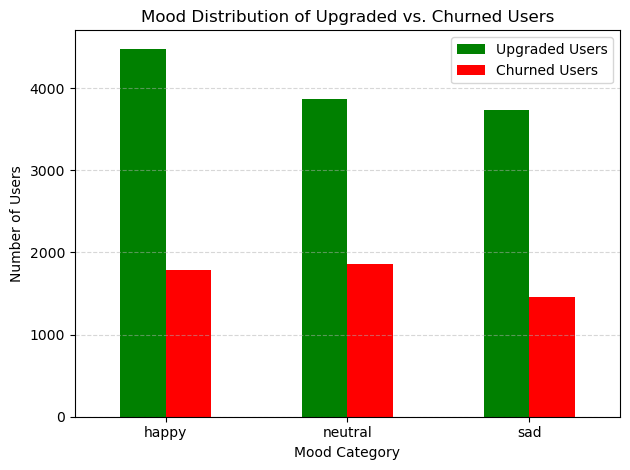

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Count moods
upgrade_counts = upgrade_mood_profiles['mood_category'].value_counts().sort_index()
churn_counts = churn_mood_profiles['mood_category'].value_counts().sort_index()

# Combine into one DataFrame
mood_comparison = pd.DataFrame({
    'Upgraded Users': upgrade_counts,
    'Churned Users': churn_counts
}).fillna(0).astype(int)

# Plot
mood_comparison.plot(kind='bar', color=['green', 'red'])
plt.title('Mood Distribution of Upgraded vs. Churned Users')
plt.xlabel('Mood Category')
plt.ylabel('Number of Users')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


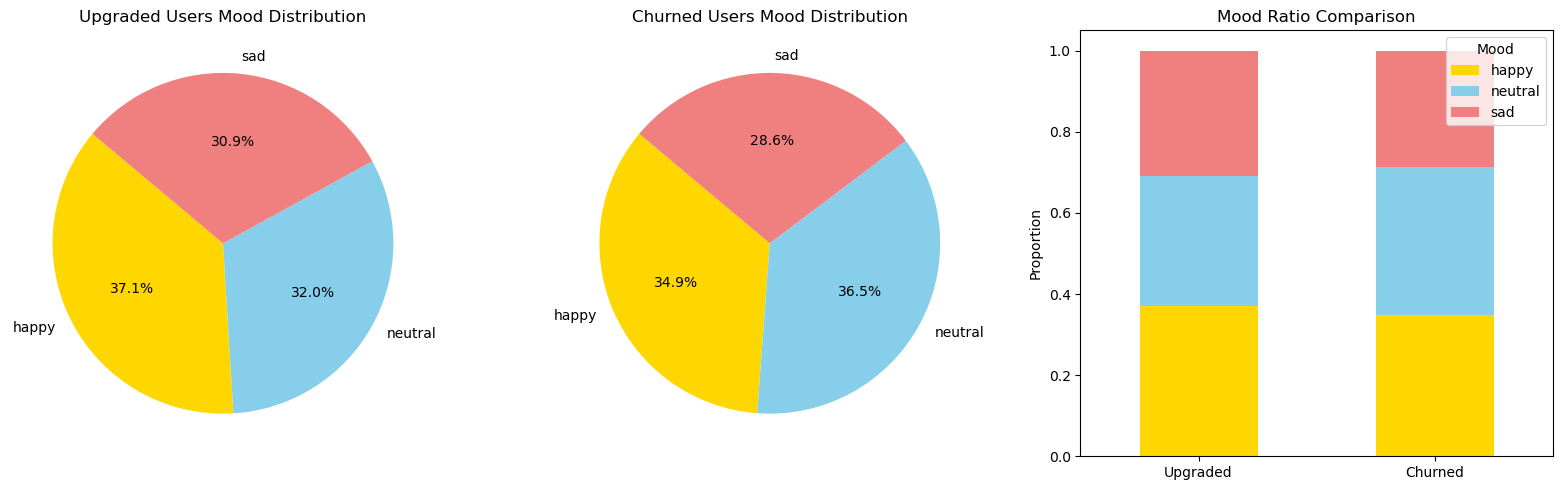

In [56]:
# Normalize to ratios
upgrade_ratios = upgrade_counts / upgrade_counts.sum()
churn_ratios = churn_counts / churn_counts.sum()

# === PLOT ===
fig, axs = plt.subplots(1, 3, figsize=(16, 5))

# Pie for Upgraded
axs[0].pie(upgrade_ratios, labels=upgrade_ratios.index, autopct='%1.1f%%', colors=['gold', 'skyblue', 'lightcoral'], startangle=140)
axs[0].set_title('Upgraded Users Mood Distribution')

# Pie for Churned
axs[1].pie(churn_ratios, labels=churn_ratios.index, autopct='%1.1f%%', colors=['gold', 'skyblue', 'lightcoral'], startangle=140)
axs[1].set_title('Churned Users Mood Distribution')

# Ratio Bar Plot
df_ratio = pd.DataFrame({
    'Upgraded': upgrade_ratios,
    'Churned': churn_ratios
}).T

df_ratio.plot(kind='bar', stacked=True, ax=axs[2], color=['gold', 'skyblue', 'lightcoral'])
axs[2].set_title('Mood Ratio Comparison')
axs[2].set_ylabel('Proportion')
axs[2].legend(title='Mood', loc='upper right')
axs[2].set_xticklabels(['Upgraded', 'Churned'], rotation=0)

plt.tight_layout()
plt.show()

### Final Mood Analysis: Upgraded vs. Churned Users

To understand the **emotional patterns of user engagement**, we visualized the distribution of song moods listened to by both **upgraded** and **churned** users.

#### 🎯 Observations:

- **Upgraded Users**:
  - Listened to **more happy songs (37.1%)**, followed closely by neutral (32.0%) and sad (30.9%).
  - Show a slightly more **positive emotional profile** overall.

- **Churned Users**:
  - Had a **higher proportion of neutral songs (36.5%)**, with happy songs at 34.9% and sad at 28.6%.
  - While still balanced, they leaned **less toward happy moods** than upgraded users.

#### 📊 Mood Ratio Comparison:
The side-by-side bar chart helps reinforce the subtle differences:
- Upgraded users lean slightly more **emotionally engaged** (more happy/sad extremes).
- Churned users show more **emotional flattening**, possibly indicating **reduced interest or connection**.

> This emotional profiling offers a fresh perspective into **user behavior and retention**, helping streaming platforms better understand what kind of content resonates with loyal users.


## 🎧 Final Analysis: Mood & User Retention in a Music Streaming App

Over 26 million records were processed from a 12GB dataset to analyze user behavior with a focus on **churn** and **upgrade** patterns. After extensive cleaning, enrichment, and normalization, the following were the core results:

### 🧠 Mood Classification Strategy

- **Multiple data sources** (Wasabi, Spotify datasets, Millsongdata) were cross-referenced to assign moods to tracks.
- **APIs and external tools** were explored:
  - Spotify API attempts failed due to rate limits.
  - GPT and Gemini were tested on unmatched songs (over 80k), with GPT eventually used in batch mode via web.
- Mood prediction methods included:
  - **VADER sentiment on lyrics**
  - **Valence-arousal based inference**
  - **Title cleaning and GPT fallback** for songs without clear matches

✅ **Result:** 142,342 / 250,372 unique songs were successfully assigned a mood label (happy / neutral / sad).

---

### 📊 Mood Distribution by User Group

Users were segmented by their subscription trajectory:
- **Upgraded** = users who moved from free → paid
- **Churned** = users who moved from paid → free

The resulting visualizations showed:

- **Upgraded Users**  
  - Happy: 37.1%  
  - Neutral: 32.0%  
  - Sad: 30.9%

- **Churned Users**  
  - Happy: 34.9%  
  - Neutral: 36.5%  
  - Sad: 28.6%

💡 **Observation:** While both groups consume a mix of moods, upgraded users tend to listen to slightly more *happy* songs, whereas churned users lean more *neutral*.

---

### ⚠️ On the 'Neutral' Mood Dominance

The *neutral* label became disproportionately common. This likely reflects:
- Missing or vague metadata
- Lyrics that lacked clear emotional indicators
- Mood approximation from title or valence when other methods failed

To maintain uniformity, mood proportions were normalized for each user. While this ensures comparability, it may **underrepresent emotional extremes** and should be considered when drawing business conclusions.

---

### 🔍 Potential for Further Insight

If time allows, next steps could include:
- **Temporal analysis**: Do mood trends change before a user churns?
- **Behavioral correlations**: Do happy-mood listeners spend longer on the platform?
- **Recommendation simulation**: What if we injected more happy songs into churned user playlists?

---

### 🧠 Business Implication

> This study suggests that emotional context (inferred from listening patterns) may offer early signals of churn. Platforms should explore emotionally-aware recommendation engines that retain users by boosting engagement during emotionally sensitive phases.
